In [33]:
import data_transformer as transformer
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal

In [2]:
X, y = transformer.make_input_target()

Subject:   0%|          | 0/7 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/1006 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/1006 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/1542 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/1542 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/2419 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/2419 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/1891 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/1891 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/671 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/671 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/263 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/263 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/210 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/210 [00:00<?, ?it/s]

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
print('Training:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Training: (2724,) (2724,)
Validation: (1343,) (1343,)


In [5]:
X_train_mat = []
for i in trange(len(X_train), desc='loadmat'):
    path = X_train[i]
    mat = loadmat(path)
    X_train_mat.append(mat)

loadmat:   0%|          | 0/2724 [00:00<?, ?it/s]

In [13]:
def get_segment(mat):
    segment_name = list(mat.keys())[-1]
    segment = mat[segment_name]
    return segment

In [14]:
def get_sig(mat):
    segment = get_segment(mat)
    sig = segment['data'][0][0]
    return sig

In [15]:
def get_fs(mat):
    "Returns the sampling frequency."
    segment = get_segment(mat)
    fs = segment['sampling_frequency'][0][0][0][0]
    return fs

In [45]:
def get_channels(mat):
    segment = get_segment(mat)
    channels = segment['channels'][0][0][0]
    return channels

In [20]:
def plot_eeg(mat, size_horizontal=8, size_vertical=4):
    segment = get_segment(mat)
    sig = segment['data'][0][0]
    ch = segment['channels'][0][0][0]
    N = sig.shape[1]
    fs = segment['sampling_frequency'][0][0][0][0]
    t = np.arange(0, N) / fs
    vspace = 1500
    bases = vspace * np.arange(ch.shape[0])
    EEG = sig.T + bases
    plt.figure(figsize=(size_horizontal, size_vertical))
    plt.plot(t, EEG, color='k')
    plt.gca().yaxis.set_ticks(bases)
    plt.gca().yaxis.set_ticklabels(ch)
    plt.xlabel('Time (s)')
    plt.tight_layout()

In [17]:
print(X_train[0])
get_sig(X_train_mat[0]).shape

./data/Dog_5/Dog_5/Dog_5_interictal_segment_0280.mat


(15, 239766)

The raw data here is the signal, which is a $(15 \times 239766)$ matrix representing a 10 min EEG recording for Dog 5. We will call this a data segment matrix. This data segment matrix is a collection of vectors holding micro-voltages recorded from each of the 15 electrodes. A preview is shown below.

In [22]:
get_sig(X_train_mat[0])

array([[ 60,  12,  60, ...,   2, -19,  30],
       [-33,  20, -36, ..., -47,  29, -18],
       [ 14,  14,  -3, ...,  12,  34,  16],
       ...,
       [-16,  58, -12, ..., -35,  28, -29],
       [-13,  -7,  27, ...,  29, -10,  -6],
       [-35,  -5, -15, ...,   1,  24,  28]], dtype=int16)

Further, we can also visualise this segment.

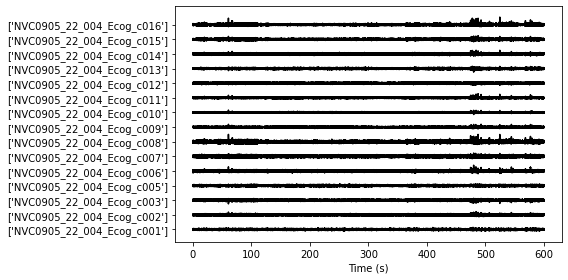

In [21]:
plot_eeg(X_train_mat[0])

In [69]:
# select channel c001 for experimentation.
x = get_sig(X_train_mat[0])[0,:]
fs = get_fs(X_train_mat[0])

Text(0, 0.5, '$\\mu V$')

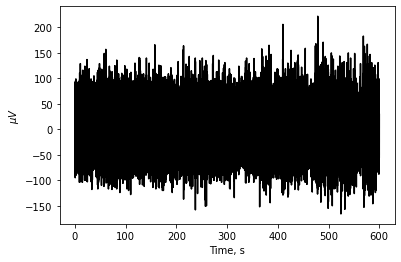

In [76]:
# plot raw signal
N = x.shape[0]
t = np.arange(0, N) / fs
plt.plot(t, x, '-', color='k')
plt.xlabel('Time, s')
plt.ylabel('$\mu V$')

# Filtering

According to (A. Affes, 2019), in America, EEG signal recordings are contaminated by 60Hz power line noise. Additional artifacts are attributed to the 0 Hz frequency.

A band-pass filter allows signal in a specified band of frequencies and blocks signals outside of this range. A band-stop filter is the opposite of a band-pass filter.

A notch filter is a band-stop filter which rejects a narrow frequency band and leaves the rest of spectrum unchanged. We use the notch filter to reject the 60 Hz frequency.

In [85]:
b, a = signal.iirnotch(w0=60.0, Q=30, fs=fs)
x_fil = signal.lfilter(b, a, x)

Text(0, 0.5, '$\\mu V$')

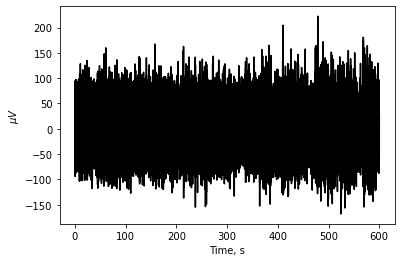

In [86]:
# plot filtered signal
N = x_fil.shape[0]
t = np.arange(0, N) / fs
plt.plot(t, x_fil, '-', color='k')
plt.xlabel('Time, s')
plt.ylabel('$\mu V$')

For comparison, we now use a 1 - 47Hz bandpass filter, which has seen promising results with EEG seizure detection applications in a similar dataset.

In [107]:
b, a = signal.butter(4, [1, 47], btype='bandpass', fs=fs)
y = signal.lfilter(b, a, x)

Text(0, 0.5, '$\\mu V$')

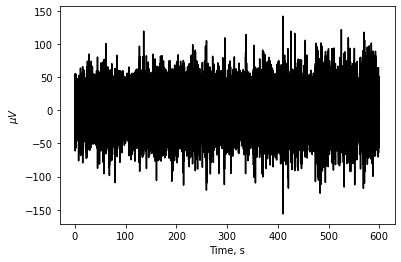

In [108]:
# visualise
N = y.shape[0]
t = np.arange(0, N) / fs
plt.plot(t, y, '-', color='k')
plt.xlabel('Time, s')
plt.ylabel('$\mu V$')

The visualisation shows the upper range was over 200$\mu V$ before filtering. After filtering, the maximum is below 150 $\mu V$. We now perform further comparison by using a Butterworth band-stop filter around 47-53 Hz.

In [109]:
b, a = signal.butter(4, [47, 53], btype='bandstop', fs=fs)
y = signal.lfilter(b, a, x)

Text(0, 0.5, '$\\mu V$')

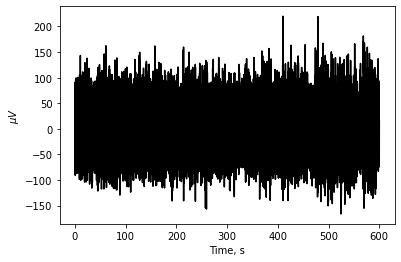

In [110]:
# visualise
N = y.shape[0]
t = np.arange(0, N) / fs
plt.plot(t, y, color='k')
plt.xlabel('Time, s')
plt.ylabel('$\mu V$')

## Filter Comparison

We now compare the following filters by applying them to all other channels in this segment:

- Butterworth Band-pass filter (1-47Hz)
- Notch filter (60Hz)

In [117]:
# 1-47Hz band-pass filter on all channels
fs = get_fs(X_train_mat[0])
b, a = signal.butter(4, [1, 47], btype='bandpass', fs=fs)
sig = get_sig(X_train_mat[0])
ys = []
for i in trange(sig.shape[0], desc='bandpass_filter'):
    x = sig[i,:]
    y = signal.lfilter(b, a, x)
    ys.append(y)

bandpass_filter:   0%|          | 0/15 [00:00<?, ?it/s]

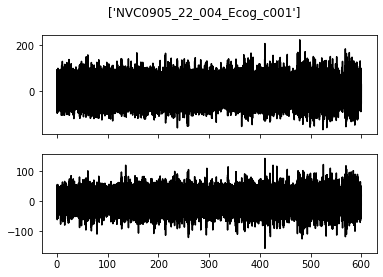

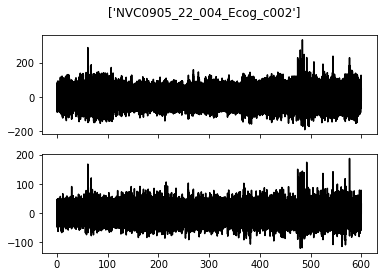

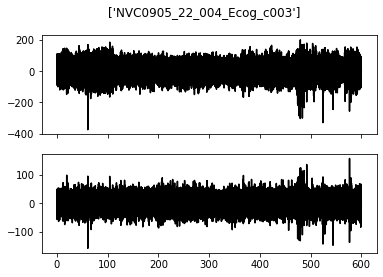

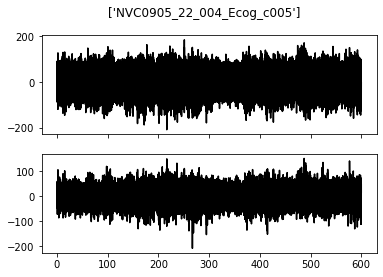

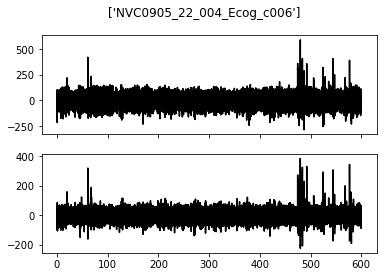

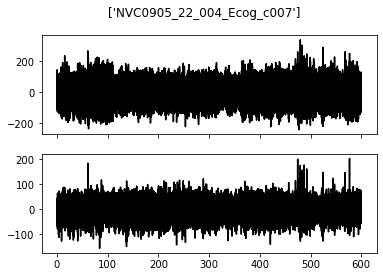

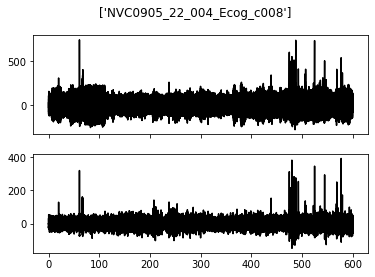

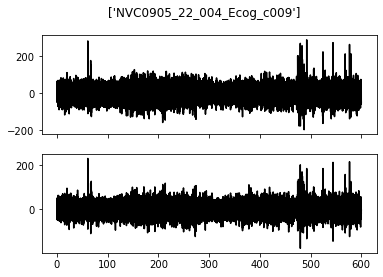

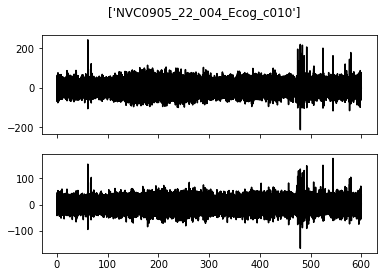

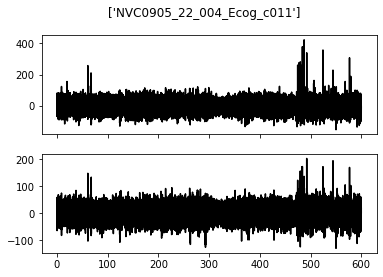

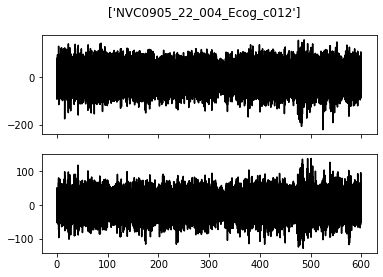

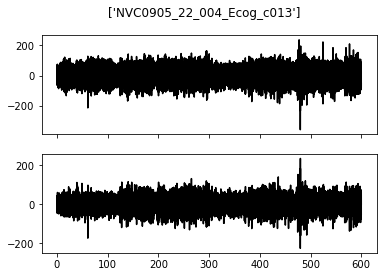

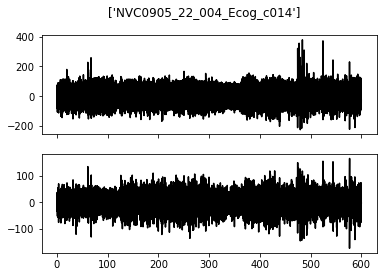

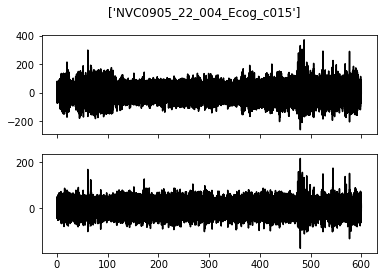

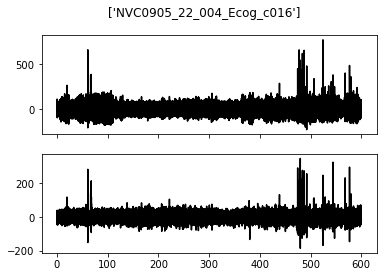

In [134]:
# visualise before and after filtering with band-pass
channels = get_channels(X_train_mat[0])
for i in range(channels.shape[0]):
    N1 = sig[i].shape[0]
    N2 = ys[i].shape[0]
    t1 = np.arange(0, N1) / fs
    t2 = np.arange(0, N2) / fs

    fig, ax = plt.subplots(2, sharex=True)
    fig.suptitle(channels[i])
    ax[0].plot(t1, sig[i], 'k')
    ax[1].plot(t2, ys[i], 'k')

In [135]:
# 60Hz notch filter
fs = get_fs(X_train_mat[0])
b, a = signal.iirnotch(w0=60.0, Q=30, fs=fs)
sig = get_sig(X_train_mat[0])
ys = []
for i in trange(sig.shape[0], desc='notch_filter'):
    x = sig[i,:]
    y = signal.lfilter(b, a, x)
    ys.append(y)

notch_filter:   0%|          | 0/15 [00:00<?, ?it/s]

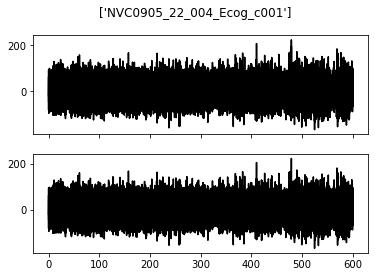

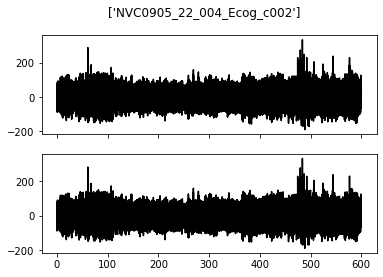

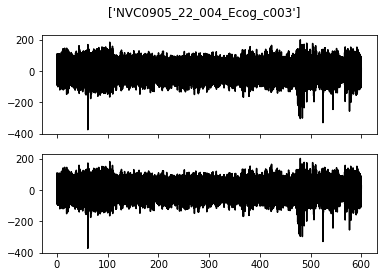

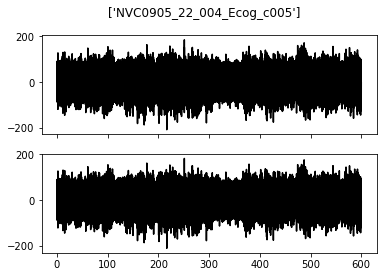

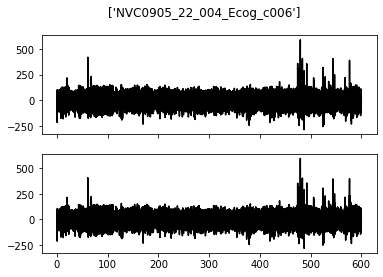

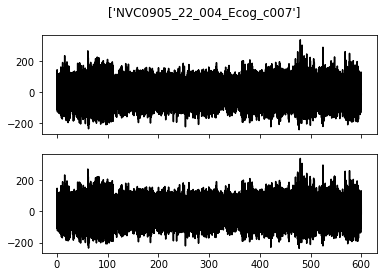

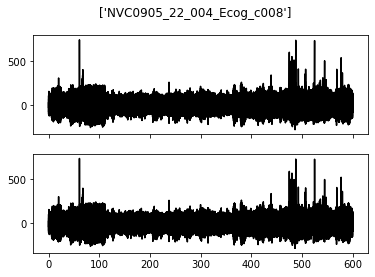

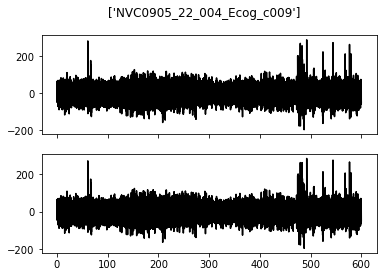

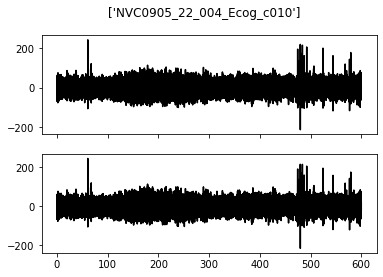

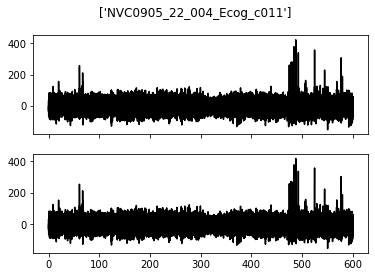

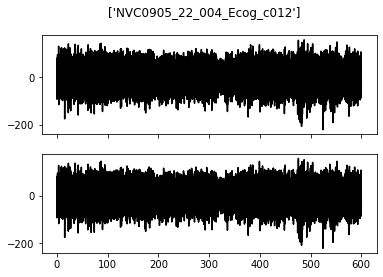

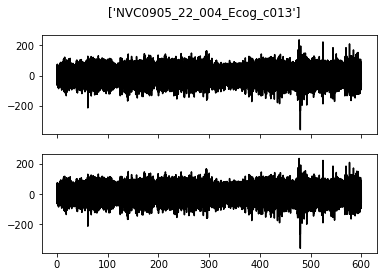

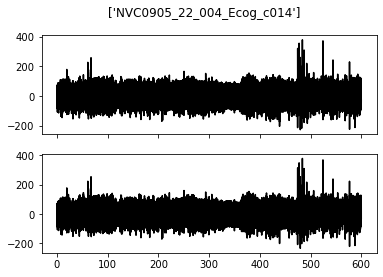

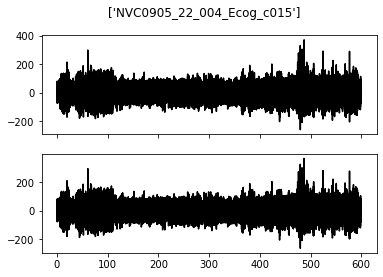

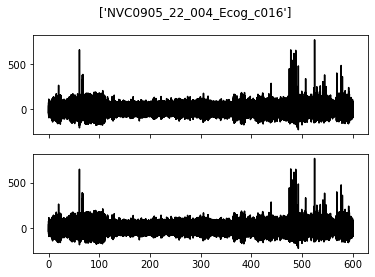

In [136]:
# visualise before and after filtering with notch
channels = get_channels(X_train_mat[0])
for i in range(channels.shape[0]):
    N1 = sig[i].shape[0]
    N2 = ys[i].shape[0]
    t1 = np.arange(0, N1) / fs
    t2 = np.arange(0, N2) / fs

    fig, ax = plt.subplots(2, sharex=True)
    fig.suptitle(channels[i])
    ax[0].plot(t1, sig[i], 'k')
    ax[1].plot(t2, ys[i], 'k')

The above comparison shows that the 1-47Hz bandpass filter is more effective at filtering out the noise in this particular segment.

**Question:** Based on this, can we conclude this filter is better for all other, interictal and preictal segments? 

We know that previously, the winner of a seizure detection challenge succeeded with this [approach](https://github.com/MichaelHills/seizure-detection).

# Feature Extraction

Due to the high dimension of the data, the learning algorithm will suffer from the curse of dimensionality. This curse can be broken with feature extraction and dimensionality reduction. 

The benefit of breaking the curse is that the accuracy of the learning algorithm will be increased and training time will decrease.

Since we have ~100GB+ data, a shorter training time is preferable.

Thus, our pre-processing step will aim to perform feature extraction so dimensionality of data can be reduced.

Literature shows that applying STFT and producing spectrogram is a popular preprocessing step.

In [139]:
x = get_sig(X_train_mat[0])[0,:]
fs = get_fs(X_train_mat[0])

In [149]:
# STFT
f, t, Zxx = signal.stft(x, fs)

In [150]:
print(f.shape)
print(t.shape)
print(Zxx.shape)
print(x.shape)

(129,)
(1875,)
(129, 1875)
(239766,)


Text(0, 0.5, 'Frequency, Hz')

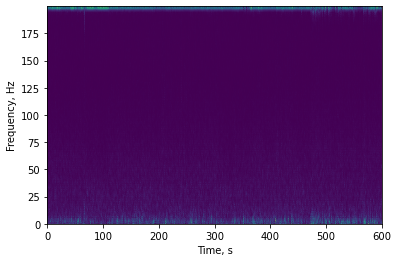

In [151]:
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.xlabel('Time, s')
plt.ylabel('Frequency, Hz')

**Question:** How can we interpret the above spectrogram?

**Todo:** Investigate how spectrograms are produced from Short Term Fourier Transform.

---

What forms of EEG signal feature extraction methods are available?

Spectral Density Estimation (SDE) is one method of feature extraction. It estimates the power spectral density of a signal from a sequence of time samples. The spectral density characterises the frequency content of the signal.

SDE can be done in two ways: non-parametric and parametric. Non-parametric approach estimates the spectrum of the signal generating process without assuming the process has a particular structure. Parametric spectral estimation assumes the signal is modelled by a stationary process.

SDE can be performed by applying Fast Fourier Transform (FFT), which breaks the incoming signal into a type of power spectrum known as a periodogram. A periodogram is a non-parametric approach to SDE. 

Source: [Wikipedia - Spectral density estimation](https://en.wikipedia.org/wiki/Spectral_density_estimation)


What form should this data be converted to, so that we can use traditional machine learning algorithms?

Literature shows there are two approaches:
- Discrete Wavelet Transform (DWT)
- Short-Time Fourier Transform (STFT)

These preserve time information while extracting frequency information and other EEG features.

One goal could be to construct a function that maps a feature vector from the data segment matrix to a correct labelling of the segment.

In this case, each EEG channel could be a feature.
